In [ ]:
! uv pip install pyarrow

In [1]:
# %reload_ext autoreload
# %autoreload 2
# %aimport czbenchmarks.datasets.utils_single_cell
import czbenchmarks.datasets.utils_single_cell as scp

import os
import scanpy as sc
import pandas as pd
import anndata as ad
import numpy as np
from pandas.testing import assert_frame_equal
import matplotlib.pyplot as plt

In [2]:
deg_name = 'wilcoxon'

## Load Data

In [3]:
filtered_data_path = f"{os.environ['HOME']}/.cz-benchmarks/datasets/replogle_k562_essential_perturbpredict_de_results_control_cells.h5ad"
# filtered_data_path = "/data2/czbenchmarks/replogle2022/K562_essential_raw_singlecell_01.h5ad"
adata_filtered = ad.read_h5ad(filtered_data_path, backed=None)

In [4]:
de_results = pd.DataFrame(adata_filtered.uns[f"de_results_{deg_name}"])
# de_results['condition'] = de_results['condition'].cat.remove_unused_categories()
de_results['condition'] = de_results['condition'].astype(str)

control_cells_ids = adata_filtered.uns["control_cells_ids"]
control_cells_ids.pop("non-targeting", None)

array([], dtype=float64)

In [5]:
cr4_data_path = (
    "/data2/czbenchmarks/replogle2022/raw_h5ad_from_cr4/K562_essential_mtx.h5ad"
)
adata_cr4 = ad.read_h5ad(cr4_data_path, backed=None)
adata_cr4.var.index.name = "gene_id"
adata_cr4.var.rename(columns={"gene_name": "gene"}, inplace=True)
adata_cr4.obs.rename(columns={"gene_id": "condition"}, inplace=True)

## Compare Keys and Shapes

In [6]:
adata_cr4.shape, adata_filtered.shape, de_results.shape

((310385, 32628), (310385, 8563), (20793007, 7))

In [7]:
# The only missing condition is non-targeting (i.e. the control)
print(deg_name)
print(
    set(adata_filtered.obs.condition.unique())
    - set(de_results.condition.unique())
)
print(
    set(de_results.condition.unique())
    - set(adata_filtered.obs.condition.unique())
)

wilcoxon
{'non-targeting'}
set()


## Run DGE Analysis

In [9]:
print(deg_name)
# num_conditions = 10
# condition_list = np.asarray(list(control_cells_ids.keys()))
# condition_list = np.random.choice(condition_list, size=num_conditions, replace=False)
# new_control_cells_ids = {k: control_cells_ids[k] for k in condition_list}
new_control_cells_ids = control_cells_ids 
min_pert_cells=1 # 1, 50

results = scp.run_multicondition_dge_analysis(
    adata=adata_cr4,
    condition_key="condition",
    control_name="non-targeting",
    control_cells_ids=new_control_cells_ids,
    deg_test_name=deg_name,
    filter_min_cells=10,  # 0, 10
    filter_min_genes=10,  # 0, 1000
    min_pert_cells=min_pert_cells,  # 1, 50
    remove_avg_zeros=False,
    return_merged_adata=False,
)

results.to_parquet(f"/data2/compare_de_results_{deg_name}_min_pert_cells_{min_pert_cells}.arrow")



wilcoxon


Processing de conditions: 100%|██████████████████████████████████████████████████████████████| 2057/2057 [07:14<00:00,  4.74item/s, Completed 2057/2057]


## Or load from disk

In [11]:
# results = pd.read_parquet(f"/data2/compare_de_results_{deg_name}.arrow")

In [12]:
print(deg_name, results.shape, de_results.shape)

wilcoxon (20793007, 6) (20793007, 7)


In [13]:
32628 * 2057

67115796

## Define Intersection / Unique Sets

In [14]:
# Create a column with condition / gene_id to filter the data for similarity
def zip_names(df):
    condition = df['condition'].astype(str).values
    gene_id = df['gene_id'].astype(str).values
    mapper = list(map(lambda x: '_'.join([x[0], x[1]]), zip(condition, gene_id)))
    return mapper

results['mapper'] = zip_names(results)
de_results['mapper'] = zip_names(de_results)

print(results.shape, de_results.shape)
print("condition", results['condition'].nunique(), de_results['condition'].nunique())
print("gene_id", results['gene_id'].nunique(), de_results['gene_id'].nunique())
print(len(results['mapper']), len(de_results['mapper']))

(20793007, 7) (20793007, 8)
condition 2057 2057
gene_id 15730 15730
20793007 20793007


In [15]:
# All generated condition/gene pairs are a part of the previous generated condition/gene pairs
print(set(results['mapper']).issubset(set(de_results['mapper'])))
print(set(results['condition']).issubset(set(de_results['condition'])))

True
True


In [16]:
unique_condition_gene_pairs = list(set(de_results['mapper']) - set(results['mapper']))
shared_condition_gene_pairs = list(set(de_results['mapper']).intersection(set(results['mapper'])))

unique_conditions = list(set(de_results['condition']) - set(results['condition']))
shared_conditions = list(set(de_results['condition']).intersection(set(results['condition'])))

print(len(unique_condition_gene_pairs), len(shared_condition_gene_pairs))
print(len(unique_conditions), len(shared_conditions))

0 20793007
0 2057


In [17]:
import json
with open(f"/data2/unique_conditions_{deg_name}.json", 'w') as fh:
    json.dump(unique_conditions, fh)

In [18]:
unique_condition_gene_df = pd.DataFrame(map(lambda x: x.split('_'), unique_condition_gene_pairs))
if unique_condition_gene_df.shape[1] > 0:
    unique_condition_gene_df.columns = ['condition', 'gene_id']

print(len(unique_condition_gene_df))
if len(unique_condition_gene_df) > 0:
    unique_condition_gene_df.head()
else:
    unique_condition_gene_df = None

0


In [19]:
common_columns = sorted(set(de_results.columns).intersection(results.columns))
de_columns = [c for c in de_results.columns if c not in common_columns]
r_columns  = [c for c in results.columns if c not in common_columns]

In [20]:
s_de_results = de_results[common_columns].set_index('mapper').loc[shared_condition_gene_pairs]
s_results = results[common_columns].set_index('mapper').loc[shared_condition_gene_pairs]

## Examine Differences

In [21]:
de_results_unique_counts = (
    de_results
        .set_index('condition')
        .loc[unique_conditions]
        .groupby(level=0)
        .count()
        .describe()
)
de_results_unique_counts

,gene_id,condition_name,score,logfoldchange,pval,pval_adj,mapper
count,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Compare Common Conditions / Gene IDs

In [22]:
  with pd.option_context('display.width', 10000, 'display.max_columns', 100):
    print(s_de_results.head())
    print(s_results.head())

                                       condition          gene_id  logfoldchange      pval  pval_adj     score
mapper                                                                                                        
ENSG00000183751_ENSG00000171943  ENSG00000183751  ENSG00000171943       1.258297  0.575445  0.999036  0.560050
ENSG00000105669_ENSG00000079999  ENSG00000105669  ENSG00000079999       0.440239  0.065199  0.999619  1.843890
ENSG00000161057_ENSG00000143624  ENSG00000161057  ENSG00000143624      -0.276767  0.379470  1.000000 -0.878874
ENSG00000165119_ENSG00000170515  ENSG00000165119  ENSG00000170515      -0.404464  0.006042  0.303681 -2.745503
ENSG00000130520_ENSG00000069275  ENSG00000130520  ENSG00000069275       0.135674  0.587505  0.998868  0.542455
                                       condition          gene_id  logfoldchange      pval  pval_adj     score
mapper                                                                                                        
E

In [23]:
s_de_results_counts = (
    s_de_results
        .set_index('condition')
        ['gene_id']
        .groupby(level=0)
        .count()
)

s_results_counts = (
    s_results
        .set_index('condition')
        ['gene_id']
        .groupby(level=0)
        .count()
)

print(s_de_results_counts.head())
print(s_results_counts.head())

condition
ENSG00000001497     9889
ENSG00000003509     5410
ENSG00000004779    10746
ENSG00000004897    12173
ENSG00000005007    10546
Name: gene_id, dtype: int64
condition
ENSG00000001497     9889
ENSG00000003509     5410
ENSG00000004779    10746
ENSG00000004897    12173
ENSG00000005007    10546
Name: gene_id, dtype: int64


In [24]:
print(assert_frame_equal(
    s_de_results_counts.to_frame(),
    s_results_counts.to_frame(),
))

None


In [25]:
assert_frame_equal(
    s_de_results,
    s_results,
    check_dtype=False,
    check_index_type=False,
    check_categorical=False,
    atol=1.5e-2
)

In [26]:
diff_columns = ['logfoldchange', 'pval', 'pval_adj', 'score']
diff_results = (
    s_de_results[diff_columns] -
    s_results[diff_columns]
)
diff_results.head()

,logfoldchange,pval,pval_adj,score
mapper,,,,
ENSG00000183751_ENSG00000171943,-4.734344e-08,0.000000e+00,-1.110223e-16,-2.791367e-08
ENSG00000105669_ENSG00000079999,-2.636719e-09,-5.551115e-17,1.110223e-16,4.829407e-08
ENSG00000161057_ENSG00000143624,-4.740524e-09,-5.551115e-17,0.000000e+00,-4.531403e-09
ENSG00000165119_ENSG00000170515,-4.959793e-09,-9.801188e-17,-5.551115e-17,-1.282043e-08
ENSG00000130520_ENSG00000069275,-1.765270e-08,0.000000e+00,0.000000e+00,5.596161e-09


In [27]:
diff_results_describe = diff_results.describe()
diff_results_describe

,logfoldchange,pval,pval_adj,score
count,2.079301e+07,2.079301e+07,2.079301e+07,2.079301e+07
mean,1.824320e-10,-2.012767e-10,5.008864e-08,-8.381522e-08
std,2.320684e-08,1.877916e-05,1.068245e-05,3.209338e-05
min,-2.393188e-06,-1.079110e-02,-8.414247e-03,-1.352514e-02
25%,-5.721750e-09,-2.775558e-17,0.000000e+00,-4.035454e-09
50%,3.408103e-11,0.000000e+00,0.000000e+00,0.000000e+00
75%,6.207275e-09,0.000000e+00,0.000000e+00,4.033089e-09
max,2.273804e-06,1.074972e-02,4.952018e-03,6.713547e-03


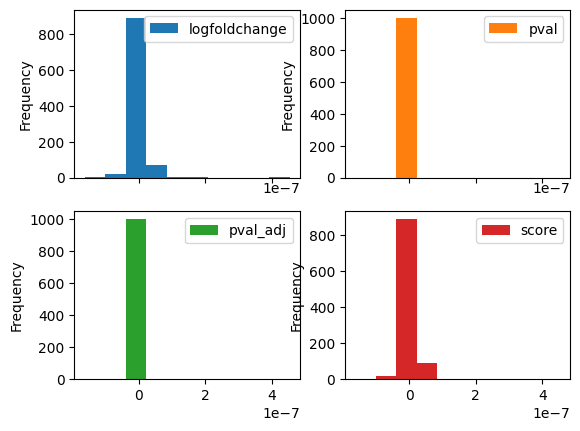

In [28]:
axes = diff_results.head(n=1000).plot(kind='hist', subplots=True, layout=(2,2)) # , bins=100, sharex=False, 
# for pos,ax in enumerate(axes.flatten()):
#     ax.set_xlim(diff_results_describe.loc['min'].iloc[pos], diff_results_describe.loc['max'].iloc[pos])
#     ax.set(title=diff_results.columns[pos])

## Misc Checks for Other Files

In [ ]:
# Verify Target Conditions to Save
import json

with open("../target_conditions_to_save.json", "r") as f:
    target_conditions_to_save = json.load(f)

condition_list = set(map(lambda x: x.split("_")[1], target_conditions_to_save.keys()))

target_conditions_to_save_new = {}
for key, value in target_conditions_to_save.items():
    condition = key.split("_")[1]
    if condition not in target_conditions_to_save_new:
        target_conditions_to_save_new[condition] = value
    else:
        assert target_conditions_to_save_new[condition] == value


In [ ]:
# Validate that existing control cells ids exist in data
skipped_conditions = []
# Convert index to set for O(1) lookup instead of O(n) for each check
index_set = set(adata_filtered.obs.index.values)
for key, values in control_cells_ids.items():
    if key not in adata_filtered.obs.condition:
        skipped_conditions.append(key)
    else:
        assert all(x in index_set for x in values), f"{values} not in {adata_filtered.obs.index.values}"

print(f"Skipped conditions: {skipped_conditions}")
